In [2]:
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
from matplotlib import pyplot as plt

h_dir = os.getcwd()

# Step 1: Prepare text for future processing

In [3]:
# Create csv file with labels

text = open(h_dir + '/experimental_data')
raw_data = text.read().split(';')
for i in range(len(raw_data)):
    raw_data[i] = raw_data[i].split('\n')
    filter_obj = filter(lambda x: x!='', raw_data[i])
    raw_data[i] = list(filter_obj)
    
raw_data.pop(0)
    
# print(raw_data)

['№ Каталога', 'Опушение', 'Вегетация', 'Порядковый номер', 'Диплоиды']

# Step 2: Create dataframe to import in into csv using patterns of regex

In [4]:
def list_to_str(lst):
    res_str = ''
    for x in lst:
        res_str += x + ';'
    return res_str


df = pd.DataFrame({'Номер_каталога': [],
                   'Вид_злаков':[],
                   'Вид':[],
                   'Опушение':[],
                   'Вегетация':[],
                   'Порядковые_номера':[]
                  })

spec_patt = r'T\.\s\w*'
species = ''

ear_patt = r'([А-Я][а-я]*)'
ear_kind = 'Диплоиды'

veg_patt = ''
num_patt = ''
    
for x in raw_data:
    if not x:
        continue
    # in this case we consider only spicies of wheat and ear kinds (as you may see they are lists 1 lenght)
    if len(x) == 1:
        res = re.search(spec_patt, x[0])
        if res:
            species = res.group()
        else:
            res = re.search(ear_patt, x[0])
            if res:
                ear_kind = res.group()
    # otherways we consider specific species of wheat
    else:
        catalog_num = x[0]
        pubescence = 0
        veg = []
        ord_num = []
        if x[1] == '+':
            pubescence = 1
            
        # regex patterns to distinguish vegetation for order numbers
        veg_patt = r'(X|Х|I){1,2}-?\d{2}'
        ord_patt = r'\d{2,4}-?(\d{2,4})?'
        for i in [i+2 for i in range(len(x)-2)]:
            res = re.search(veg_patt, x[i])
            if res:
                veg.append(res.group())
            else:
                res = re.search(ord_patt, x[i])
                if res:
                    ord_num.append(res.group())
        # add data into dataframe
        df = df.append(pd.DataFrame({'Номер_каталога': [catalog_num],
                   'Вид_злаков':[ear_kind],
                   'Вид':[species],
                   'Опушение':[str(pubescence)],
                   'Вегетация':[list_to_str(veg)],
                   'Порядковые_номера':[list_to_str(ord_num)],
                  }))

# df ---> csv
df.to_csv('labels.csv', index=False)

In [5]:
tmp = df.loc[df['Порядковые_номера'].str.contains('7691-7700')]
print(tmp.loc[tmp['Опушение'] == '0'])

  Номер_каталога   Вид_злаков           Вид Опушение         Вегетация  \
0    ANDW5AP17AL  Тетраплоиды  T. polonicum        0  X-19;II-20;X-20;   

            Порядковые_номера  
0  7892-99;7691-7700;6721-30;  


# Step 3: Exploratory data analysis

In [6]:
# Go through file system and calculate general num of images
pin_dir = r'/pin'
table_dir = r'/table'
pin_patt = r'\d{2,4}_[^,(I|l)]_\{[ХXI]{1,2}-?\d{2,4}\}\.(jpg|JPG)$'
table_patt = r'\d{2,4}_\{[ХXI]{1,2}-?\d{2,4}\}\.(jpg|JPG)$'
spec_patt = r'T\.\s?[\w]+'
ord_patt = r'\d{2,4}-?\d{0,4}'
spec_dist = {}
# value [x,y] means: x - overall number of imgs, y - number of pubescence img
pin_count = 0
table_count = 0

# Check species distribution and overall number of examples
for dirpath, dirnames, filenames in os.walk('/data/cv_project/spikedroid/ploid_classification'):
    if re.search(pin_dir, dirpath):
        spec = re.search(spec_patt, dirpath).group()
        for fn in filenames:
            if re.search(pin_patt, fn):
                # define does this species have pubescence
                pubesc = 0
                tmp1 = df.loc[df['Вид'] == spec]
                tmp2 =  tmp1.loc[tmp1['Порядковые_номера'].str.contains(re.search(ord_patt, dirpath).group())]
                if not tmp2.loc[tmp2['Опушение'] == True].empty:
                    pubesc = 1
                if spec not in spec_dist.keys():
                    spec_dist[spec] = [0,0]
                else:
                    spec_dist[spec][0] += 1
                    spec_dist[spec][1] += pubesc
                pin_count += 1
                
    if re.search(table_dir, dirpath):
        spec = re.search(spec_patt, dirpath).group()
        for fn in filenames:
            if re.search(table_patt, fn):
                # define does this species have pubescence
                pubesc = 0
                tmp1 = df.loc[df['Вид'] == spec]
                tmp2 =  tmp1.loc[tmp1['Порядковые_номера'].str.contains(re.search(ord_patt, dirpath).group())]
                if not tmp2.loc[tmp2['Опушение'] == True].empty:
                    pubesc = 1
                if spec not in spec_dist.keys():
                    spec_dist[spec] = [0,0]
                else:
                    spec_dist[spec][0] += 1
                    spec_dist[spec][1] += pubesc
                table_count += 1
                
overall = table_count+pin_count
print('Всего изображений на прищепке:', pin_count)
print('Всего изображений на столе:', table_count)
print('Всего изображений:', overall)
print()
df = pd.read_csv(h_dir + '/labels.csv')
print('Образцов с опушением:', len(df[df['Опушение'] == 1]))
print('Образцов без опушения:', len(df[df['Опушение'] == 0]) )
print(spec_dist)
print(spec_dist.keys())
sum_1 = 0
for x in spec_dist.values():
    sum_1 += x[0] - x[1]
print(sum_1)

Всего изображений на прищепке: 7607
Всего изображений на столе: 1901
Всего изображений: 9508

Образцов с опушением: 54
Образцов без опушения: 108
{'T. monococcum': [654, 0], 'T. boeoticum': [144, 0], 'T. urartu': [124, 0], 'T. yunnanense': [129, 0], 'T. aestivum': [294, 0], 'T. compactum': [134, 0], 'T. spelta': [99, 0], 'T. macha': [249, 0], 'T. vavilovii': [179, 0], 'T. petropavlovskyi': [458, 0], 'T. durum': [1086, 0], 'T. timopheevii': [874, 0], 'T. dicoccoides': [578, 0], 'T. turanicum': [39, 0], 'T. carthlicum': [819, 0], 'T. turgidum': [634, 0], 'T. dicoccum': [832, 0], 'T. aethiopicum': [1339, 0], 'T. polonicum': [824, 0]}
dict_keys(['T. monococcum', 'T. boeoticum', 'T. urartu', 'T. yunnanense', 'T. aestivum', 'T. compactum', 'T. spelta', 'T. macha', 'T. vavilovii', 'T. petropavlovskyi', 'T. durum', 'T. timopheevii', 'T. dicoccoides', 'T. turanicum', 'T. carthlicum', 'T. turgidum', 'T. dicoccum', 'T. aethiopicum', 'T. polonicum'])
9489


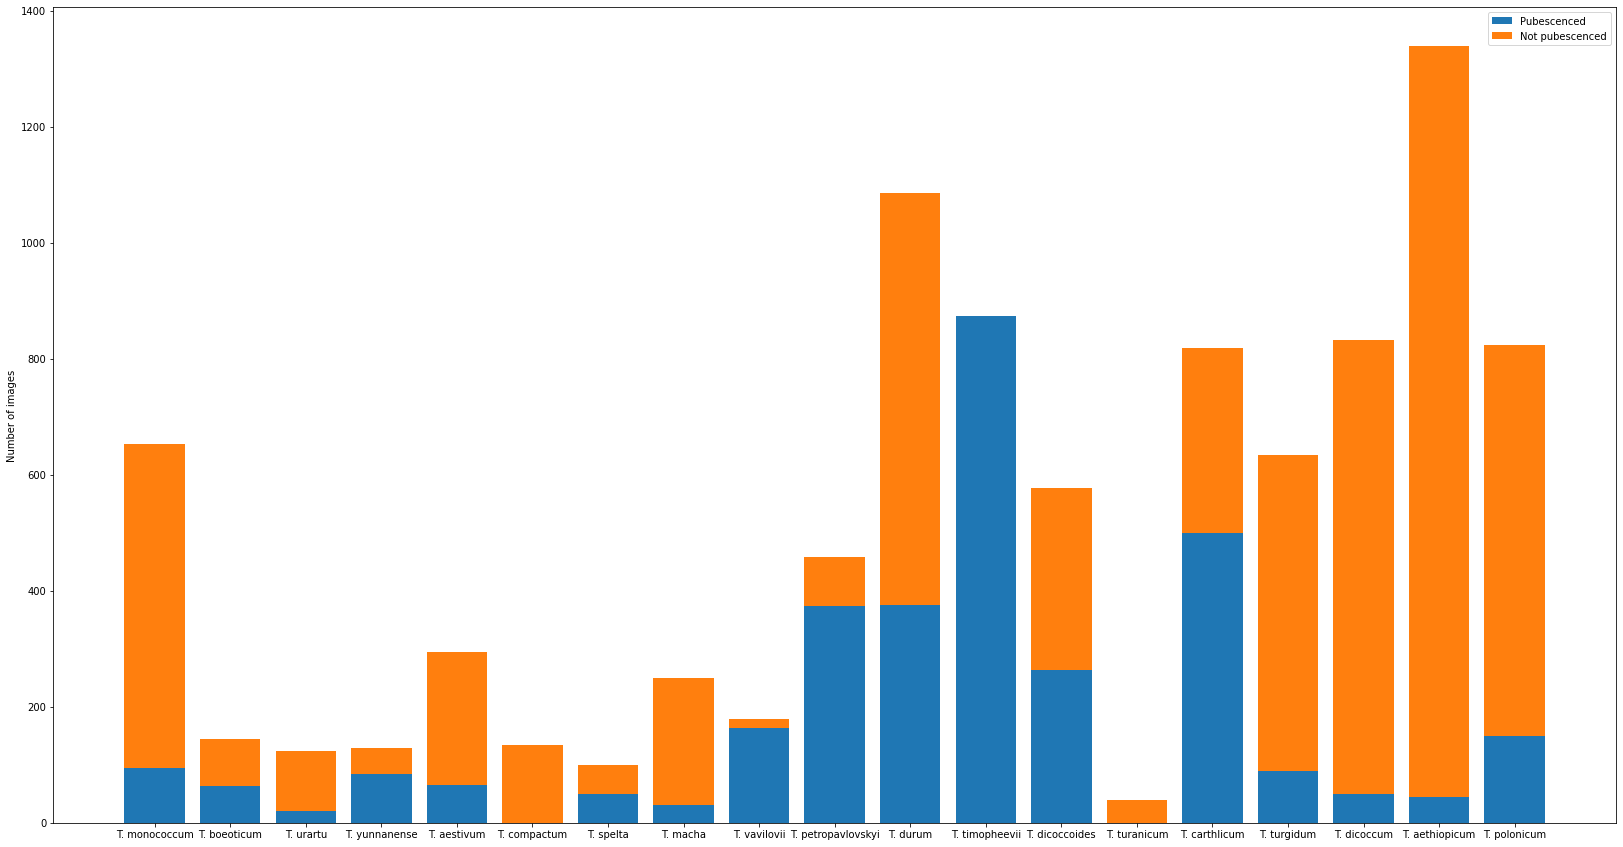

In [8]:
labels = spec_dist.keys()
pubesc = [x[1] for x in spec_dist.values()]
non_pubesc = [x[0]-x[1] for x in spec_dist.values()]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(28,15))

ax.bar(labels, pubesc, label='Pubescenced')
ax.bar(labels, non_pubesc, bottom=pubesc, label='Not pubescenced')

ax.set_ylabel('Number of images')
ax.legend()

plt.show()
fig.savefig(h_dir + '/hyst_pub.png')

# Step 4: Create file with images, lables and samples name

In [ ]:
# Used for extract species for training
def GetSpecies(dataset_type='test'):
    test = ['T. boeoticum', 'T. vavilovii', 'T. polonicum']
    valid = ['T. macha', 'T. dicoccoides']
#     test = ['T. petropavlovskyi', 'T. monococcum', 'T. turanicum']
#     valid = ['T. durum', 'T. yunnanense']
    if dataset_type == 'test':
        return test
    elif dataset_type == 'valid':
        return valid
    elif dataset_type == 'train':
        spec_patt = r'T.\s\w*'
        data_dir = '/data/cv_project/spikedroid/ploid_classification'
        res = []
        
        # take all name of species
        for dirpath, dirnames, filenames in os.walk(data_dir):
            for dn in dirnames:
                re_res = re.search(spec_patt, dn)
                if re_res:
                    res.append(re_res.group())
        
        # get away from lame species
        for x in test:
            res.remove(x)
        for x in valid:
            res.remove(x)
        return res
    else:
        return None
    
def create_file():
    def get_label(img_path):
        subspec_patt = r'\d{2,5}-?(\d{2,5})?'
        spec_patt = r'T\.\s\w*'
        veg_patt = r'(Х|X|I){1,2}-?\d{2}'
        # get name of subspecies and species
        subspec = re.search(subspec_patt, img_path).group()
        spec = re.search(spec_patt, img_path).group()
        veg = re.search(veg_patt, img_path).group()
            
        # get the label according to species and subspecies
        df = pd.read_csv('/home/jupyter-n.artemenko/projects/spikelet_pubescence/labels.csv')
        tmp1 = df.loc[df['Вид'] == spec]
        tmp2 = tmp1.loc[tmp1['Порядковые_номера'].str.contains(subspec)]
        tmp3 = tmp2.loc[tmp2['Вегетация'].str.contains(veg)]
        if tmp3.empty:
            veg = veg.replace('X', 'Х')
            tmp3 = tmp2.loc[tmp2['Вегетация'].str.contains(veg)]
        if tmp3.empty:
            veg = veg.replace('Х', 'X')
            tmp3 = tmp2.loc[tmp2['Вегетация'].str.contains(veg)]
        
        # there are subspecies without any labels
        if not tmp3.empty:
            return int(tmp3.iloc[0]['Опушение'])
        elif not tmp2.empty:
            print(tmp2, spec, subspec, veg)
            return None
    
    def get_sample(img_path):
        spec_patt = r'T.\s\w*'
        res = re.search(spec_patt, img_path).group()
    
        for x in ['train', 'valid', 'test']:
            if res in GetSpecies(x):
                return x
        return None
    
    out = open('sample_split.txt', 'w')
    h_dir = '/data/cv_project/spikedroid/ploid_classification'
    
    # patterns for images
    pin_patt = r'[\d]{2,5}_[^,(I|l)]_\{[ХXI]{1,2}-?\d{2,4}\}\.(jpg|JPG)$'
    table_patt = r'[\d]{2,5}_\{[ХXI]{1,2}-?\d{2,4}\}\.(jpg|JPG)$'
    for dirpath, dirnames, filenames in os.walk(h_dir):
        for fn in filenames:
            res1 = re.search(pin_patt, fn)
            res2 = re.search(table_patt, fn)
            if res1 or res2:
                # choose one not none value
                res = ''
                if res1:
                    res = res1
                else:
                    res = res2
                part1 = dirpath+'/'+res.group()
                part2 = str(get_label(dirpath+'/'+fn))
                part3 = get_sample(dirpath)
                if part2 != 'None':
                    # print(part1+' '+part2+' '+part3)
                    out.write(part1+';'+part2+';'+part3+'\n')
    out.close()
        
create_file()